In [1]:

import numpy as np
import cvxpy as cp

# Re-run setup after code reset
import numpy as np
import os
import math
from scipy.special import comb, hermite
from itertools import product
from qutip import Qobj, wigner, basis
from qutip import fidelity
from qutip import coherent
import matplotlib.pyplot as plt
from tqdm import tqdm

def setup(W, xvec, yvec, N, rho_exact):
    global E_ops

    # === Step 2: Normalize Wigner → probabilities w_k ===
    dx = xvec[1] - xvec[0]
    dy = yvec[1] - yvec[0]
    b = np.nanmean(W[0, :])  # crude background estimate at top edge
    a = 1 / (np.nansum(W - b) * dx * dy)  # normalization constant

    print("a = ", a, "b = ", b)

    W_physical = a * (W - b)
    W_physical = np.nan_to_num(W_physical, nan=0.0)
    w_k = 0.5 * (1 + (np.pi / 2) * W_physical)
    w_k = w_k.ravel()

    # === Step 3: Create α_k grid (from x + ip) ===
    X, Y = np.meshgrid(xvec, yvec)
    alphas = (X + 1j * Y).ravel()

    E_ops = np.load('E_ops/E_ops_chunk_0_N50_x6_100_y6_100.npy')
    E_ops = E_ops[:, :N, :N]#Qobj(E_ops[:N, :N], dims=[[N], [N]])
    rho_exact = Qobj(rho_exact.full()[:N, :N], dims=[[N], [N]])  # target density matrix

    def plot_vertical_slice_residuals(E_ops, w_k, rho_exact, xvec, yvec):
        """
        Plot Tr(E_k ρ_exact) vs w_k along Re(α) = 0
        """
        predicted = []
        for E in E_ops:
            E_np = E#.full()
            # E_np = np.array(E_np, dtype=complex)
            predicted.append(np.real(np.trace(E_np @ rho_exact.full())))

        predicted = np.array(predicted)
        grid_size = xvec.shape[0]#int(np.sqrt(len(predicted)))

        predicted_2D = predicted.reshape((grid_size, grid_size))
        w_k_2D = np.array(w_k).reshape((grid_size, grid_size))

        x_index = np.abs(np.array(xvec) - 0).argmin()
        y_axis = np.array(yvec)

        pred_slice = predicted_2D[:, x_index]
        wk_slice = w_k_2D[:, x_index]

        plt.figure(figsize=(6, 4))
        plt.plot(y_axis, pred_slice, label='Tr(E_k ρ)', lw=2)
        plt.plot(y_axis, wk_slice, label='w_k from Wigner', lw=2, linestyle='--')
        plt.xlabel("Im(α)")
        plt.ylabel("Probability")
        plt.title("Vertical Slice: Predicted vs. Wigner Probabilities")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    plot_vertical_slice_residuals(E_ops, w_k, rho_exact, xvec, yvec)


    
    



    safe_mask = np.abs(alphas) < 3




    def reconstruct_density_matrix(E_ops, w_k, N):
        """
        Solve the SDP to reconstruct the density matrix ρ.

        Inputs:
            E_ops: list of Qobj measurement operators E_k
            w_k: measurement probabilities
            N: Hilbert space dimension

        Returns:
            rho_opt (np.ndarray): estimated density matrix (N x N)
        """
        rho = cp.Variable((N, N), hermitian=True)

        constraints = [
            rho >> 0,                 # positive semidefinite
            cp.trace(rho) == 1        # normalized
        ]

        residuals = []
        for i, (E, w) in enumerate(zip(E_ops, w_k)):
            if not safe_mask[i]:
                continue  # skip unsafe regions
            E_np = E#.full()
            predicted = cp.real(cp.trace(E_np @ rho))
            residuals.append(predicted - w)

        loss = cp.sum_squares(cp.hstack(residuals))
        problem = cp.Problem(cp.Minimize(loss), constraints)
        problem.solve(solver=cp.SCS, verbose=True)

        print("Optimization status:", problem.status)
        print("Final loss:", problem.value)

        return rho.value


    rho_est = reconstruct_density_matrix(E_ops, w_k, N)

    return rho_est



In [2]:
# def compute_safe_region_residual(E_ops, w_k, rho_exact, safe_mask):
#     """
#     Compute L2 residual norm and mean error between predicted Tr(E ρ) and w_k,
#     restricted to the safe region.
#     """
#     predicted = []
#     for E in E_ops:
#         E_np = E#.full()
#         predicted.append(np.real(np.trace(E_np @ rho_exact)))

#     predicted = np.array(predicted)
#     residuals = predicted - np.array(w_k)

#     residuals_safe = residuals[safe_mask]

#     l2_norm = np.linalg.norm(residuals_safe)
#     mse = np.mean(residuals_safe**2)
#     max_dev = np.max(np.abs(residuals_safe))

#     print(f"Residual in safe region (|α| < 3):")
#     print(f"  L2 norm  = {l2_norm:.4e}")
#     print(f"  MSE      = {mse:.4e}")
#     print(f"  Max dev  = {max_dev:.4e}")

#     return residuals_safe

# residuals_safe = compute_safe_region_residual(E_ops, w_k, rho_exact, safe_mask)

In [3]:
# def plot_2d_residuals_safe(E_ops, w_k, rho_exact, alphas, xvec, yvec, threshold=4):
#     """
#     Plot 2D residuals Tr(E_k ρ) - w_k, masking out |α| >= threshold.

#     Inputs:
#         E_ops: list of measurement operators
#         w_k: array of Wigner-derived probabilities
#         rho_exact: true density matrix (as numpy array)
#         alphas: complex grid of α_k = x + ip, flattened
#         xvec, yvec: 1D coordinate arrays (grid axes)
#         threshold: modulus cutoff for trusted region
#     """
#     # Evaluate predicted
#     predicted = np.array([np.real(np.trace(E @ rho_exact)) for E in E_ops])
#     residuals = predicted - np.array(w_k)

#     # Apply safe mask
#     safe_mask = np.abs(alphas) < threshold
#     residuals_masked = np.full_like(residuals, np.nan)
#     residuals_masked[safe_mask] = residuals[safe_mask]

#     # Reshape to 2D
#     grid_size_x = len(xvec)
#     grid_size_y = len(yvec)
#     residuals_2D = residuals_masked.reshape((grid_size_x, grid_size_y))

#     # Plot
#     plt.figure(figsize=(6, 5))
#     plt.pcolormesh(xvec, yvec, residuals_2D, shading='auto', cmap='bwr', vmin=-0.02, vmax=0.02)
#     plt.colorbar(label='Residual: Tr(E_k ρ) - w_k')
#     plt.xlabel("Re(α)")
#     plt.ylabel("Im(α)")
#     plt.title(f"2D Residuals in |α| < {threshold}")
#     plt.tight_layout()
#     plt.show()

# plot_2d_residuals_safe(E_ops, w_k, rho_exact, alphas, xvec, yvec, threshold=3)


In [4]:
# import matplotlib.pyplot as plt
# import numpy as np

# def plot_density_matrix(rho_hat):
#     """
#     Visualize the reconstructed density matrix.
    
#     Inputs:
#         rho_hat (np.ndarray): estimated density matrix (complex)
#     """
#     fig, axes = plt.subplots(1, 2, figsize=(10, 4))

#     im0 = axes[0].imshow(np.real(rho_hat), cmap='viridis')
#     axes[0].set_title("Magnitude |ρᵢⱼ|")
#     fig.colorbar(im0, ax=axes[0])

#     im1 = axes[1].imshow(np.imag(rho_hat), cmap='twilight', vmin=-np.pi, vmax=np.pi)
#     axes[1].set_title("Imag(ρᵢⱼ)")
#     fig.colorbar(im1, ax=axes[1])

#     for ax in axes:
#         ax.set_xlabel("j")
#         ax.set_ylabel("i")
#         ax.set_xticks(np.arange(rho_hat.shape[0]))
#         ax.set_yticks(np.arange(rho_hat.shape[0]))

#     plt.tight_layout()
#     plt.show()

# plot_density_matrix(rho_est)


In [5]:
# # import pickle
# # # Load the density matrix
# # with open('data/synthetic/quantum_state_1.pickle', 'rb') as f:
# #     rho_data = pickle.load(f)

# # rho_data = np.array(rho_data)
# plot_density_matrix(rho_exact)

In [6]:
from qutip import Qobj
from qutip import fidelity

def calc_fidelity(rho_target, rho_reconstructed, N):
    """
    Calculate fidelity and mean squared error between target and reconstructed density matrices.
    """
    rho_t = Qobj(np.abs(rho_target), dims=[[N], [N]])
    rho_r = Qobj(np.abs(rho_reconstructed), dims=[[N], [N]])

    fid = fidelity(rho_t, rho_r)
    msq = np.mean(np.abs((rho_t.full() - rho_r.full()))**2)

    return float(fid), float(msq)


def plot_rho_comparison(rho_target, rho_reconstructed, scale=1.0):
    """
    Plot real parts of true vs reconstructed density matrix.
    """
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    im0 = axes[0].imshow(np.real(rho_target) * scale, cmap='viridis')
    axes[0].set_title("Target $\\rho$")
    fig.colorbar(im0, ax=axes[0])

    im1 = axes[1].imshow(np.real(rho_reconstructed) * scale, cmap='viridis')
    axes[1].set_title("Reconstructed $\\hat{\\rho}$")
    fig.colorbar(im1, ax=axes[1])

    plt.tight_layout()
    plt.show()

a =  50.05482704597504 b =  -0.0008362462793534446


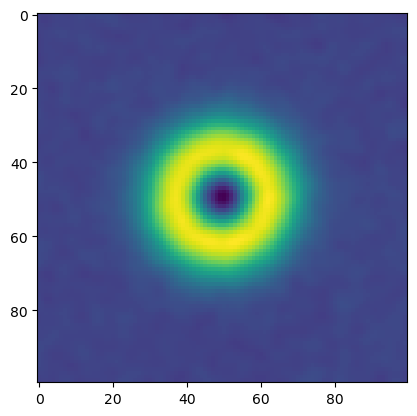

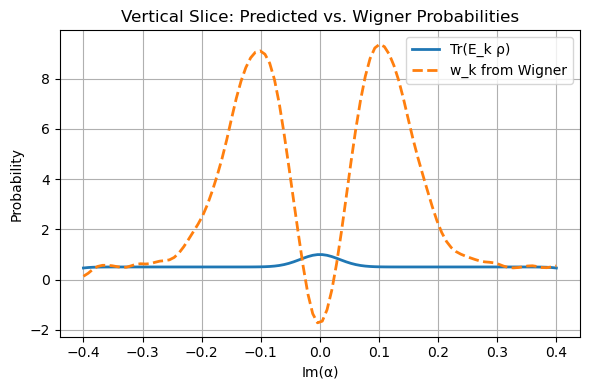

                                     CVXPY                                     
                                     v1.6.5                                    
(CVXPY) May 11 11:03:33 AM: Your problem has 100 variables, 101 constraints, and 0 parameters.


/opt/miniconda3/envs/py11_SymRegr/lib/python3.11/site-packages/cvxpy/problems/problem.py:158: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "


(CVXPY) May 11 11:03:33 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 11 11:03:33 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 11 11:03:33 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) May 11 11:03:33 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 11 11:03:34 AM: Compiling problem (target solver=SCS).
(CVXPY) May 11 11:03:34 AM: Reduction chain: Complex2Real -> Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> SCS
(CVXPY) May 11 11:03:34 AM: Applying reduction Complex2Real
(CVXPY) May 11 11:03:34 AM: Applying reduction Dcp2Cone
(CVXPY) May 11 11:03:36 

/opt/miniconda3/envs/py11_SymRegr/lib/python3.11/site-packages/cvxpy/problems/problem.py:164: UserWarning: Constraint #0 contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn(f"Constraint #{i} contains too many subexpressions. "


(CVXPY) May 11 11:03:37 AM: Applying reduction ConeMatrixStuffing
(CVXPY) May 11 11:05:05 AM: Applying reduction SCS
(CVXPY) May 11 11:05:05 AM: Finished problem compilation (took 9.181e+01 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) May 11 11:05:05 AM: Invoking solver SCS  to obtain a solution.
------------------------------------------------------------------
	       SCS v3.2.7 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
------------------------------------------------------------------
problem:  variables n: 10100, constraints m: 10211
cones: 	  z: primal zero / dual free vars: 10001
	  s: psd vars: 210, ssize: 1
settings: eps_abs: 1.0e-05, eps_rel: 1.0e-05, eps_infeas: 1.0e-07
	  alpha: 1.50, scale: 1.00e-01, adaptive_scale: 1
	  max_iters:

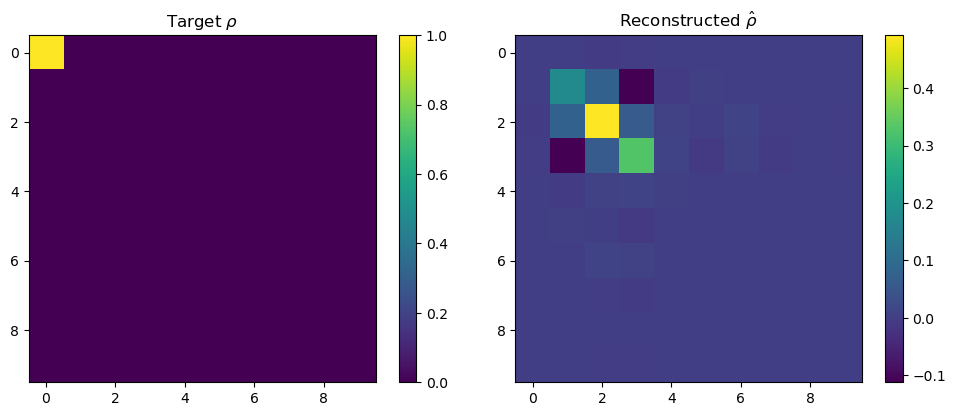

In [7]:
import os
import csv
import pickle


import numpy as np
import cvxpy as cp

# Re-run setup after code reset
import numpy as np
import os
import math
from scipy.special import comb, hermite
from itertools import product
from qutip import Qobj, wigner, basis
from qutip import fidelity
from qutip import coherent
import matplotlib.pyplot as plt
from tqdm import tqdm

from scipy.ndimage import gaussian_filter

from scipy.interpolate import RegularGridInterpolator

def interpolate_to_small_grid(x, y, z, new_size=50):
    x_new = np.linspace(min(x), max(x), new_size)
    y_new = np.linspace(min(y), max(y), new_size)
    interpolator = RegularGridInterpolator((y, x), z)
    Xn, Yn = np.meshgrid(x_new, y_new)
    points = np.stack([Yn.ravel(), Xn.ravel()], axis=-1)
    z_interp = interpolator(points).reshape((new_size, new_size))
    return x_new, y_new, z_interp




import time
csv_filename = "brute_reconstruction_results.csv"
csv_fields = ["problem_id", "grid_size", "N","compilation_time", "reconstruction_time", "fidelity", "L2", "sigma_noise"]


# Setup CSV logging
if not os.path.exists(csv_filename):
    with open(csv_filename, mode="w", newline='') as f:
        writer = csv.writer(f)
        writer.writerow(csv_fields)

for sigma_noise in [0]:
    for problem_idx in ["wigner_fock_one"]:
        for N in [10]:

            with open(f'data/experimental/{problem_idx}.pickle', 'rb') as f:
            # with open('data/experimental/wigner_cat_minus.pickle', 'rb') as f:
                data = pickle.load(f)

            # Unpack the data
            x = data[0]  # x-axis (position or Re[α])
            y = data[1]  # y-axis (momentum or Im[α])
            z = data[2]  # 2D Wigner function values
            xvec = np.array(x) #* np.sqrt(2)
            yvec = np.array(y) #* np.sqrt(2)
            W_input = np.array(z)


            # with open(f'data/synthetic/quantum_state_{problem_idx}.pickle', 'rb') as f:
            #     data = pickle.load(f)
            # rho_exact = np.array(data)  # target density matrix
            # xvec = np.linspace(min(x), max(x), 100)
            # yvec = np.linspace(min(y), max(y), 100)
            rho_exact = basis(N, 0) * basis(N, 0).dag()  # target density matrix
            # W_input = igner(rho_exact, xvec * np.sqrt(2), yvec * np.sqrt(2))

            W_input = np.nan_to_num(W_input, nan=0.0)
            plt.imshow(W_input)
            # plt.imshow(W_input)

            # sigma_noise = 1
            sigma = sigma_noise * np.max(np.abs(W_input))
            W_input += np.random.normal(loc=0.0, scale=sigma, size=W_input.shape)
            
            W_input = gaussian_filter(W_input, sigma=1.5)

            xvec, yvec, W_input = interpolate_to_small_grid(xvec, yvec, W_input, new_size=100)

            plt.imshow(W_input)
            
            ################################################


            # Reconstruct
            # rho_hat, W_scaled, a, b, comp_time, recon_time = reconstruct_density_matrix_robust(
            #     W_input, xvec, yvec, N=N, sigma=1, grid_resize=100, n_components=300
            # )
            start_time = time.time()
            rho_hat = setup(W_input, xvec, yvec, N, rho_exact)
            recon_time = time.time() - start_time
            # Calculate fidelity
            fidelity_value, msq = calc_fidelity(rho_exact.full()[:N, :N], rho_hat[:N, :N], N)
            print(f"Fidelity between target and reconstructed density matrices: {fidelity_value}")
            print(f"L2: {msq}")

            # Plot
            plot_rho_comparison(rho_exact.full()[:N,:N], rho_hat[:N][:N])

                # Log to CSV

            comp_time = 1.84

            with open(csv_filename, mode="a", newline='') as f:
                writer = csv.writer(f)
                writer.writerow([str(problem_idx)+"nofilt", 100, N, comp_time, recon_time, fidelity_value, msq, sigma_noise])

